In [55]:
import os
import torch
import numpy as np
import math
import functools
import matplotlib.pyplot as plt
from matplotlib import animation
from torch.fft import fft, ifft
from smld.models.helpers import marginal_prob_std, diffusion_coeff
from smld.signalsamplers import circulant, align
import smld.signalsamplers as samplers
from smld.models.convolutional import Convolutional
from smld.models.MLP import MLP
from smld.utils import Euler_Maruyama_sampler
from experimental_conditioner import experimental_conditioner
from score_projection import score_projector

In [56]:
class GaussianDiffusionModel(torch.nn.Module):
    def __init__(
        self, 
        mean_vec,
        prior_sigma,
        marginal_prob_std,
    ):
        super().__init__()

        assert torch.allclose(torch.ones_like(mean_vec)*torch.mean(mean_vec), mean_vec)

        self.register_buffer("mean_vec", mean_vec)
        self.prior_sigma = prior_sigma
        self.marginal_prob_std = marginal_prob_std
    
    def forward(self, x, t):
        # print(self.marginal_prob_std(t)[:, None].item())
        return (self.mean_vec - x) / ((self.prior_sigma ** 2) + (self.marginal_prob_std(t)[:, None] ** 2))
    
    def __len__(self):
        return self.mean_vec.shape[-1]

In [72]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Current device is \'{device}\'.")
generator = torch.Generator(device=device) 
generator.seed()

# Choose the type of diffusion score model.
# Also set correct signal length and maximal diffusion sigma.
scoremodel_type = "learned" # "gaussian", "learned"
length = 41
diffusion_sigma = 3.0

# Conditioner parameters
use_none_cond = False
use_CLT = True
use_random_power_spectrum = False
use_random_true_signal = False
cond_start_frac = 0.8

# MRA parameters
M = 1000000
MRA_sigma = 10.

# If not using random signal, set true signal.
signal_true = torch.zeros(length, device=device)
signal_true[length//8:(length//8)+length//2] += 1.
# signal_true[0] = 1

# If gaussian diffusion model, set parameters.
prior_sigma = 1.
mean_true = 1.
mean_vec = mean_true * torch.ones(length, device=device)

# If learned diffusion model, set parameters.
MODEL_PATH = "./../../model_weights/smld/" 
learned_model_type = "conv" # "conv", "mlp"
hidden_layers = 8
hidden_dim = 4
embed_dim = 64
signal_sampler_type = "hat" # "hat", "loop"
signal_scale = 1.0

# Diffusion sampler parameters
model_sampler = Euler_Maruyama_sampler
diffusion_steps = 30000
diffusion_samples = 200
diffusion_epsilon = 1e-5

# Set parameters for plotting
plot_signal_samples = True
plot_projection = False
show_plot = True

# Set parameters for visualization of scores across diffusion time.
num_steps_plt = 200
min_diffusion_time_plt = 1e-2
ax_bound = 2
ax_pts = 20

# Set path where figs will be saved.
FIG_PATH = "./../figs/smld/" # NOT LOCATION SAFE
assert os.path.exists(FIG_PATH), "FIG_PATH must exist."
FIG_PATH += f"{length}/"
if not os.path.exists(FIG_PATH):
    os.makedirs(FIG_PATH)


Current device is 'cuda'.


In [73]:

## Score model setup
marginal_prob_std_fn = functools.partial(
    marginal_prob_std, 
    sigma=diffusion_sigma, 
    device=device,
)
diffusion_coeff_fn = functools.partial(
    diffusion_coeff, 
    sigma=diffusion_sigma, 
    device=device,
)

if scoremodel_type == "learned":
    assert os.path.exists(MODEL_PATH), "MODEL_PATH must exist."
    if learned_model_type == "mlp":
        scoremodel = MLP(
            marginal_prob_std_fn, 
            length, 
            hidden_dim, 
            hidden_layers, 
            embed_dim,
        ).to(device)
    elif learned_model_type == "conv":
        scoremodel = Convolutional(
            marginal_prob_std_fn, 
            length, 
            hidden_dim, 
            hidden_layers, 
            embed_dim,
        ).to(device)
    else:
        raise NotImplementedError(f"No learned model has type {learned_model_type}")

    model_name = "_".join((
        f"{str(scoremodel)}",
        f"len{length}",
        f"lay{hidden_layers}",
        f"hid{hidden_dim}",
        f"emb{embed_dim}",
        f"sigma{diffusion_sigma}",
        f"{signal_sampler_type}{signal_scale}",
    ))
    MODEL_PATH += f"{model_name}/"
    if not os.path.exists(MODEL_PATH): 
        print(f"Got an invalid {MODEL_PATH = }")
    else:
        print(f"Score model is loaded from {MODEL_PATH}")
    
    base_signal = torch.load(MODEL_PATH+"signal.pth", weights_only=True).to(device)
    if signal_sampler_type == "loop":
        signal_sampler = samplers.DegenerateLoopSampler(
            scale=signal_scale, 
            signal=base_signal, 
            length=length, 
            generator=generator, 
            device=device,
        )
    elif signal_sampler_type == "planck":
        signal_sampler = samplers.PlanckSampler(
            scale=signal_scale, 
            signal=base_signal, 
            length=length, 
            generator=generator, 
            device=device,
        )
    elif signal_sampler_type == "hat":
        signal_sampler = samplers.HatSampler(
            scale=signal_scale, 
            signal=base_signal, 
            length=length, 
            generator=generator, 
            device=device,
        )
    else: 
        raise NotImplementedError(f"No signal sampler has type {signal_sampler_type}")
    scoremodel.load_state_dict(torch.load(MODEL_PATH+"weights_dict.pth", weights_only=True))
    scoremodel.eval()
elif scoremodel_type == "gaussian":
    scoremodel = GaussianDiffusionModel(
        mean_vec=mean_vec, 
        prior_sigma=prior_sigma,
        marginal_prob_std=marginal_prob_std_fn,
    ).to(device)
    signal_sampler = samplers.GaussianSampler(
        scale=prior_sigma, 
        signal=mean_vec, 
        length=length, 
        generator=generator, 
        device=device,
    )
else: 
    raise NotImplementedError(f"No diffusion model has unimplemented type: {scoremodel_type}")


## Generate signal samples from the true prior.
signal_samples = signal_sampler(num=diffusion_samples, do_random_shifts=True).squeeze(0)

## Set the true signal for MRA purposes.
if use_random_true_signal:
    signal_true = signal_sampler(do_random_shifts=False).squeeze(0)
else:
    signal_true = signal_true

## True signal is circulated and MRA statistics are derived.
circulant_true = circulant(signal_true, dim=0)
power_spectrum_true = torch.abs(fft(signal_true, norm='ortho')).square()

MRA_sampler = samplers.GaussianSampler(
    scale=MRA_sigma, 
    signal=signal_true, 
    length=length,
    generator=generator, 
    device=device,
)
MRA_samples = MRA_sampler(num=M, do_random_shifts=True)

if use_random_power_spectrum:
    power_spectrum_sample = torch.abs(fft(MRA_samples, norm='ortho')).square().mean(dim=0)
else:
    power_spectrum_sample = power_spectrum_true + (MRA_sigma ** 2)
power_spectrum_est = power_spectrum_sample - (MRA_sigma ** 2)

## Conditioner setup
even = True if length%2 == 0 else False
# print("even is " + str(even))
if use_none_cond:
    conditioner = None
else:
    conditioner = functools.partial(
        experimental_conditioner,
        marginal_prob_std=marginal_prob_std_fn,
        rho_est=power_spectrum_est,
        M=M,
        MRA_sigma=MRA_sigma,
        even=even,
        use_CLT=use_CLT,
        device=device,
    )

Score model is loaded from ./../../model_weights/smld/conv_len41_lay8_hid4_emb64_sigma3.0_hat1.0/


In [74]:
## Generate diffusion samples
model_samples = model_sampler(
    scoremodel=scoremodel, 
    marginal_prob_std=marginal_prob_std_fn,
    diffusion_coeff=diffusion_coeff_fn, 
    length=length,
    batch_size=diffusion_samples,
    num_steps=diffusion_steps,
    eps=diffusion_epsilon,
    conditioner=conditioner,
    cond_start_frac=cond_start_frac,
    device=device,
)

In [75]:

## Print metrics

# print(model_samples.std().item())

outputs_power_spectrum_rmsd = (
    torch.abs(fft(model_samples, norm='ortho')).square() - power_spectrum_true
).square().mean(dim=-1).sqrt()

print(
    "Average RMSD between sample power spectra and the true power spectrum is: ", 
    f"{outputs_power_spectrum_rmsd.mean().item():.2f}",
)

outputs_rmsd = (
    model_samples.unsqueeze(1) - circulant_true
).square().mean(dim=-1).sqrt().min(dim=-1)[0]

print(
    "Average RMSD between model samples and the true signal is: ", 
    f"{outputs_rmsd.mean().item():.2f}",
)

outputs_mean_signs = torch.sign(model_samples.mean(dim=-1))
pos_perc_model = 100. * (torch.sum(outputs_mean_signs + 1) // 2) / diffusion_samples
signal_mean_signs = torch.sign(signal_samples.mean(dim=-1))
pos_perc_signal = 100. * (torch.sum(signal_mean_signs + 1) // 2) / diffusion_samples

print(f"Percentage of positive means among model samples: {pos_perc_model:.2f}%")
print(f"Percentage of positive means among signal samples: {pos_perc_signal:.2f}%")

Average RMSD between sample power spectra and the true power spectrum is:  0.20
Average RMSD between model samples and the true signal is:  0.33
Percentage of positive means among model samples: 75.50%
Percentage of positive means among signal samples: 100.00%


In [76]:
## Visualization

# Hyperparameters for plotting
plane_mag = signal_true.mean().item()
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "Times",
})


In [77]:

# Plot samples from diffusion sampler. ONLY FOR length = 3.
if length == 3:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    # ax.scatter(
    #     [0.],
    #     [0.],
    #     [0.],
    #     c='black',
    #     marker = 'x',
    # )
    ax.scatter(
        model_samples[:, 0].to('cpu'), 
        model_samples[:, 1].to('cpu'), 
        model_samples[:, 2].to('cpu'), 
        c='b',
        marker='.',
        label='Model samples',
    )
    ax.scatter(
        circulant_true[:, 0].to('cpu'), 
        circulant_true[:, 1].to('cpu'), 
        circulant_true[:, 2].to('cpu'), 
        c='r',
        marker='*',
        linewidth=4.,
        label='True signal',
    )
    theta = np.linspace(0, 2 * np.pi, 100)
    radius = torch.norm(signal_true - signal_true.mean()).item()
    if radius > 1e-5:
        phi = -np.pi/4
        xyz = np.stack(
            [
                radius * np.sin(theta) * np.cos(phi),
                radius * np.sin(theta) * np.sin(phi),
                radius * np.cos(theta),
            ],
            axis=0,
        ) # Start with a circle around the x-axis (theta), rotate to circle around [1, 1, 0] (phi).
        rotmat = np.array(
            [
                [0.9082704, -0.0917296, -0.4082040],
                [-0.0917296, 0.9082704, -0.4082040],
                [0.4082040, 0.4082040, 0.8165408],
            ]
        ) # Rotation by 35.26 degrees to go from circle around [1, 1, 0] to circle around [1, 1, 1].
        xyz = rotmat @ xyz
        xyz1 = xyz + signal_true[0:3].mean().item()
        xyz2 = xyz - signal_true[0:3].mean().item()
        ax.plot(xyz1[0, ...], xyz1[1, ...], xyz1[2, ...], c='red', linestyle='dotted', linewidth=1.5)
        ax.plot(xyz2[0, ...], xyz2[1, ...], xyz2[2, ...], c='red', linestyle='dotted', linewidth=1.5)
        legend_list = ['Model samples', 'True signal', 'Phase manifold']
    else:
        legend_list = ['Model samples', 'True signal']
    ax.legend(legend_list)
    ax.set_aspect('equal')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.view_init(elev=35, azim=45, roll=0)
    plt.savefig(FIG_PATH + 'model_samples_3d.png')
    ax.view_init(elev=90, azim=0, roll=0)
    plt.savefig(FIG_PATH + 'model_samples_top.png')


In [78]:

# Plot samples from signal sampler. ONLY FOR length = 3.
if length == 3 and plot_signal_samples:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(
        [0.],
        [0.],
        [0.],
        c='black',
        marker = 'x',
    )
    ax.scatter(
        signal_samples[:, 0].to('cpu'), 
        signal_samples[:, 1].to('cpu'), 
        signal_samples[:, 2].to('cpu'), 
        c='g',
        marker='.',
        label='Signal samples',
    )
    # if conditioner != None:
    #     ax.scatter(
    #         signal_true[0].to('cpu'), 
    #         signal_true[1].to('cpu'), 
    #         signal_true[2].to('cpu'), 
    #         c='r',
    #         marker='*',
    #         linewidth=4.,
    #         label='True signal',
    #     )
    #     ax.legend(['Origin', 'Signal samples', 'True signal'])
    # else:
    ax.legend(['Origin', 'Signal samples'])
    ax.set_aspect('equal')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.view_init(elev=35, azim=45, roll=0)
    plt.savefig(FIG_PATH + 'signal_samples_3d.png')
    ax.view_init(elev=90, azim=0, roll=0)
    plt.savefig(FIG_PATH + 'signal_samples_top.png')


In [79]:

# Plot signal and model samples. ONLY FOR length = 3.
if length == 3 and plot_signal_samples:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(
        [0.],
        [0.],
        [0.],
        c='black',
        marker = 'x',
    )
    ax.scatter(
        signal_samples[:, 0].to('cpu'), 
        signal_samples[:, 1].to('cpu'), 
        signal_samples[:, 2].to('cpu'), 
        c='g', 
        marker='.',
        label='Signal samples',
    )
    ax.scatter(
        model_samples[:, 0].to('cpu'), 
        model_samples[:, 1].to('cpu'), 
        model_samples[:, 2].to('cpu'), 
        c='b', 
        marker='.',
        label='Model samples',
    )
    ax.scatter(
        circulant_true[:, 0].to('cpu'), 
        circulant_true[:, 1].to('cpu'), 
        circulant_true[:, 2].to('cpu'), 
        c='r',
        marker='*',
        linewidth=4.,
        label='True signal',
    )
    theta = np.linspace(0, 2 * np.pi, 100)
    radius = torch.norm(signal_true - signal_true.mean()).item()
    if radius > 1e-5:
        phi = -np.pi/4
        xyz = np.stack(
            [
                radius * np.sin(theta) * np.cos(phi),
                radius * np.sin(theta) * np.sin(phi),
                radius * np.cos(theta),
            ],
            axis=0,
        ) # Start with a circle around the x-axis (theta), rotate to circle around [1, 1, 0] (phi).
        rotmat = np.array(
            [
                [0.9082704, -0.0917296, -0.4082040],
                [-0.0917296, 0.9082704, -0.4082040],
                [0.4082040, 0.4082040, 0.8165408],
            ]
        ) # Rotation by 35.26 degrees to go from circle around [1, 1, 0] to circle around [1, 1, 1].
        xyz = rotmat @ xyz
        xyz1 = xyz + signal_true[0:3].mean().item()
        xyz2 = xyz - signal_true[0:3].mean().item()
        ax.plot(xyz1[0, ...], xyz1[1, ...], xyz1[2, ...], c='red', linestyle='dotted', linewidth=1.5)
        ax.plot(xyz2[0, ...], xyz2[1, ...], xyz2[2, ...], c='red', linestyle='dotted', linewidth=1.5)
        ax.legend(['Origin', 'Signal samples', 'Model samples', 'True signal', 'Phase manifold'])
    else: 
        ax.legend(['Origin', 'Signal samples', 'Model samples', 'True signal'])
    ax.set_aspect('equal')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.view_init(elev=35, azim=45, roll=0)
    plt.savefig(FIG_PATH + 'all_samples_3d.png')
    ax.view_init(elev=90, azim=0, roll=0)
    plt.savefig(FIG_PATH + 'all_samples_top.png')


In [80]:

# Project unconditional scores in plane containing true signal.
# ONLY FOR length = 3
if length == 3 and plot_projection:
    F1 = functools.partial(
        score_projector, 
        scoremodel=scoremodel, 
        conditioner=None,
        plane_mag=plane_mag, 
        ax_bound=ax_bound,
        ax_pts=ax_pts,
        device=device,
    )

    S1, XY1, P1 = F1(min_diffusion_time_plt)
    XY1 = XY1.to('cpu')
    S1 = S1.to('cpu')

    fig, ax = plt.subplots()
    Q1 = ax.quiver(
        XY1[:, :, 0], 
        XY1[:, :, 1], 
        S1[:, :, 0], 
        S1[:, :, 1],
    )
    ax.set_aspect('equal', 'box')
    centers1 = plt.scatter(
        (P1 @ circulant(signal_true[:3], 0)).to('cpu')[0, :], 
        (P1 @ circulant(signal_true[:3], 0)).to('cpu')[1, :],
        c='r',
        marker='*',
        linewidth=4.,
    ) 
    theta = torch.linspace(0, 2 * np.pi, 100, device=device)
    radius = torch.norm(signal_true - signal_true.mean()).item()
    phi = -np.pi/4
    xyz = torch.stack(
        [
            radius * torch.sin(theta) * np.cos(phi),
            radius * torch.sin(theta) * np.sin(phi),
            radius * torch.cos(theta),
        ],
        axis=0,
    ) # Start with a circle around the x-axis (theta), rotate to circle around [1, 1, 0] (phi).
    rotmat = torch.tensor(
        [
            [0.9082704, -0.0917296, -0.4082040],
            [-0.0917296, 0.9082704, -0.4082040],
            [0.4082040, 0.4082040, 0.8165408],
        ],
        device=device,
    ) # Rotation by 35.26 degrees to go from circle around [1, 1, 0] to circle around [1, 1, 1].
    xyz = P1 @ ((rotmat @ xyz) + plane_mag)
    phase_manifold1 = plt.plot(xyz.to('cpu')[0, ...], xyz.to('cpu')[1, ...], c='red', linestyle='dotted', linewidth=1.5)

    plt.title(f"2D projection of unconditional scores at diffusion time {min_diffusion_time_plt}")
    fig.tight_layout()
    plt.savefig(FIG_PATH + 'unconditional_scores.png')

    # If conditioner is used, project conditional scores in plane containing true signal.
    if not use_none_cond:
        F2 = functools.partial(
            score_projector, 
            scoremodel=scoremodel, 
            conditioner=conditioner,
            plane_mag=plane_mag, 
            ax_bound=ax_bound,
            ax_pts=ax_pts,
            device=device,
        )

        S2, XY2, P2 = F2(min_diffusion_time_plt)
        XY2 = XY2.to('cpu')
        S2 = S2.to('cpu')

        fig, ax = plt.subplots()

        Q2 = ax.quiver(
            XY2[:, :, 0], 
            XY2[:, :, 1], 
            S2[:, :, 0], 
            S2[:, :, 1],
        )
        ax.set_aspect('equal', 'box')
        centers = ax.scatter(
            (P2 @ circulant(signal_true[:3], 0)).to('cpu')[0, :], 
            (P2 @ circulant(signal_true[:3], 0)).to('cpu')[1, :],
            c='r',
            marker='*',
            linewidth=4.,
        ) 
        theta = torch.linspace(0, 2 * np.pi, 100, device=device)
        radius = torch.norm(signal_true - signal_true.mean()).item()
        phi = -np.pi/4
        xyz = torch.stack(
            [
                radius * torch.sin(theta) * np.cos(phi),
                radius * torch.sin(theta) * np.sin(phi),
                radius * torch.cos(theta),
            ],
            axis=0,
        ) # Start with a circle around the x-axis (theta), rotate to circle around [1, 1, 0] (phi).
        rotmat = torch.tensor(
            [
                [0.9082704, -0.0917296, -0.4082040],
                [-0.0917296, 0.9082704, -0.4082040],
                [0.4082040, 0.4082040, 0.8165408],
            ],
            device=device,
        ) # Rotation by 35.26 degrees to go from circle around [1, 1, 0] to circle around [1, 1, 1].
        xyz = P2 @ ((rotmat @ xyz) + plane_mag)
        phase_manifold2 = plt.plot(xyz.to('cpu')[0, ...], xyz.to('cpu')[1, ...], c='red', linestyle='dotted', linewidth=1.5)

        plt.title(f"2D projection of conditional scores at diffusion time {min_diffusion_time_plt}")
        fig.tight_layout()
        plt.savefig(FIG_PATH + 'conditional_scores.png')

/tmp/ipykernel_52210/3990035718.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_m, ax_m = plt.subplots()


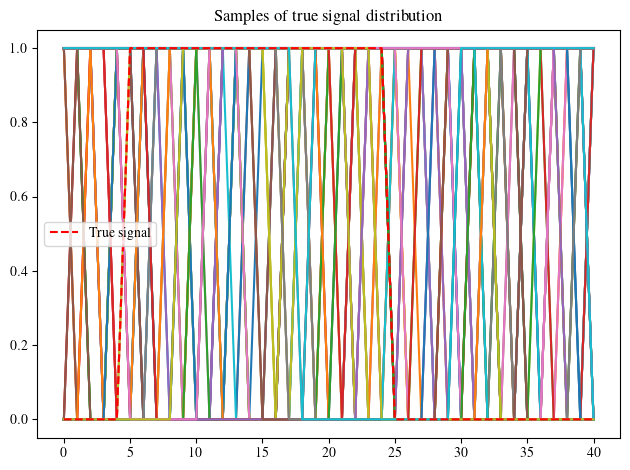

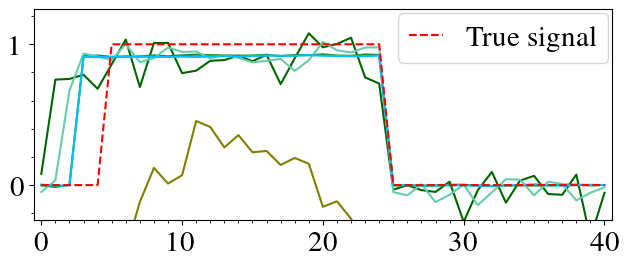

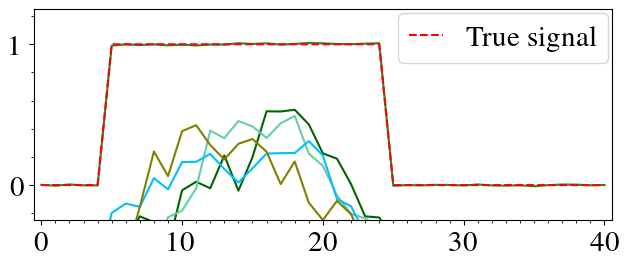

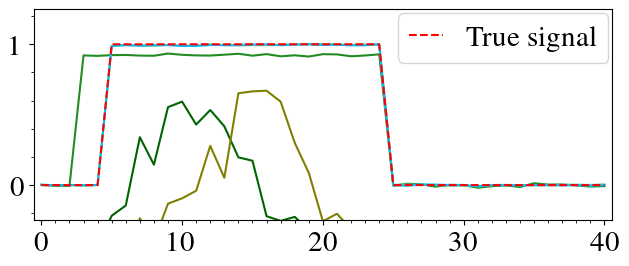

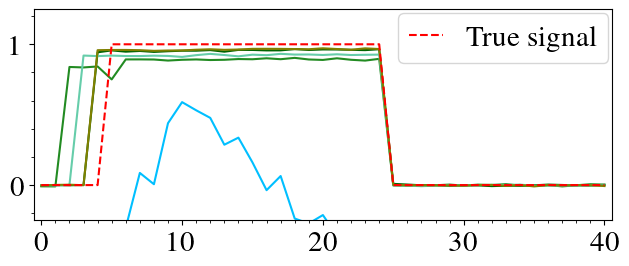

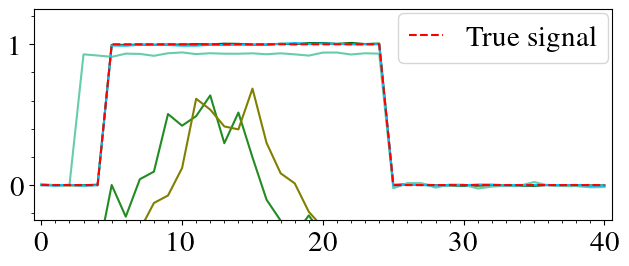

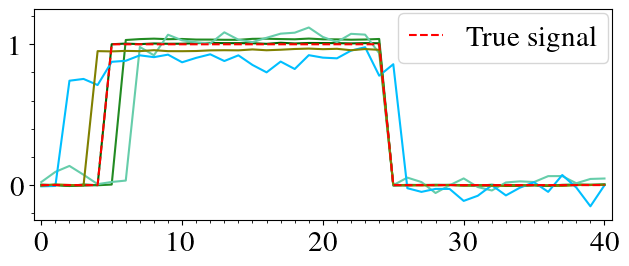

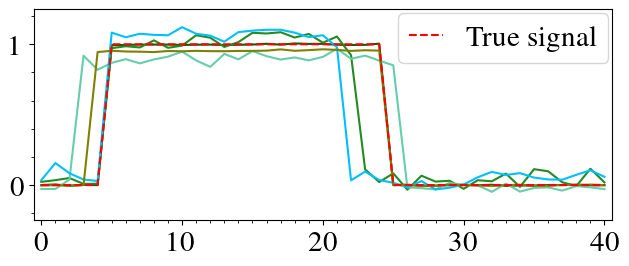

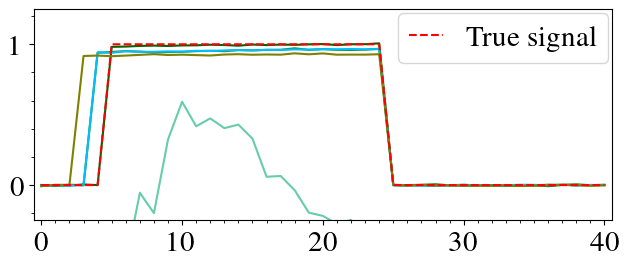

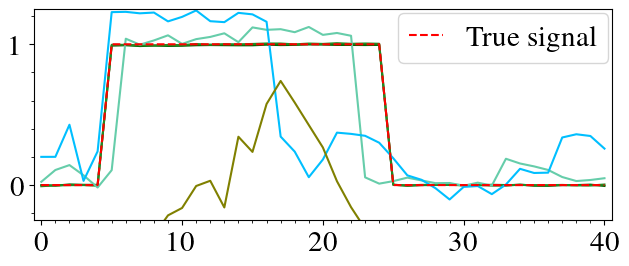

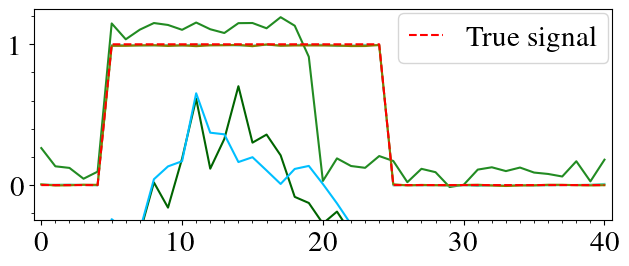

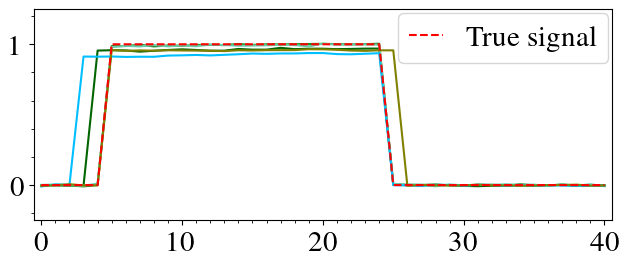

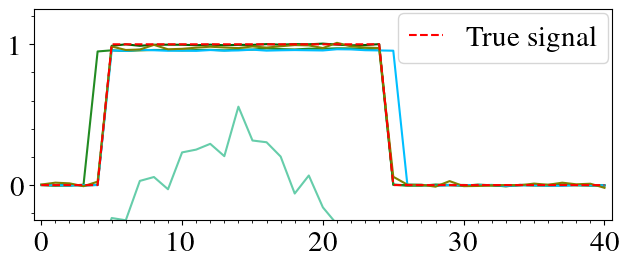

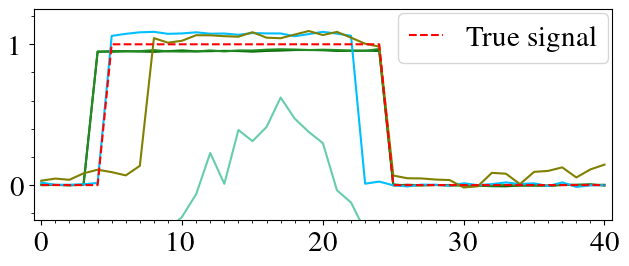

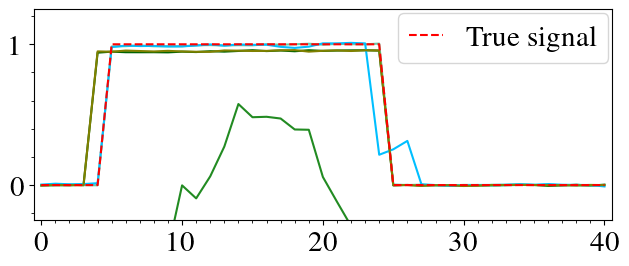

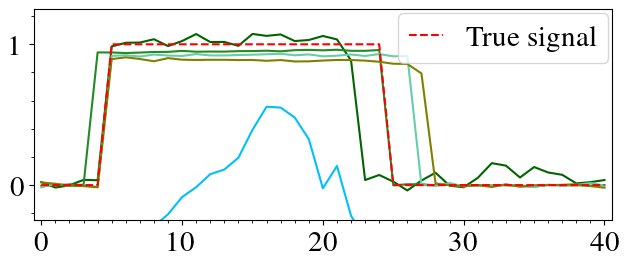

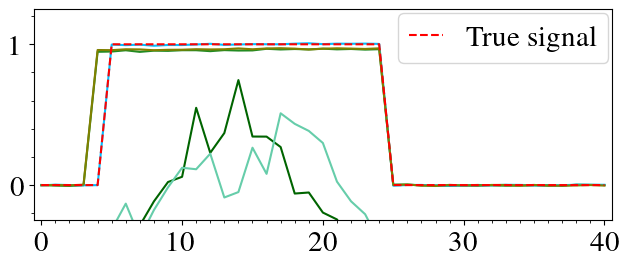

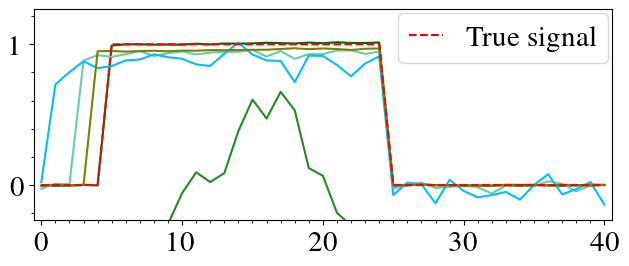

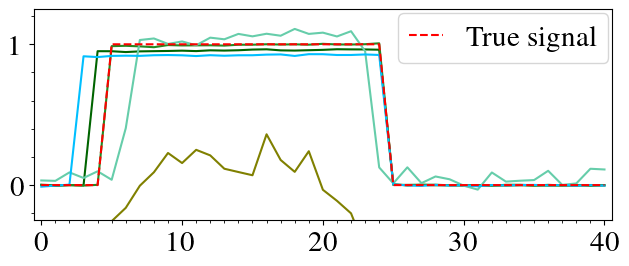

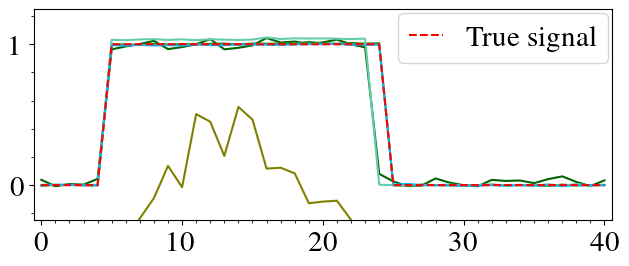

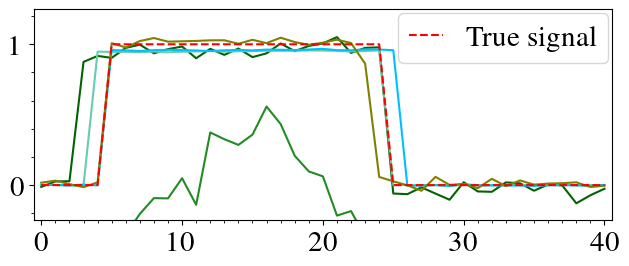

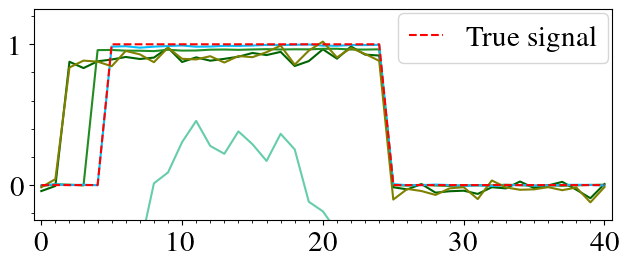

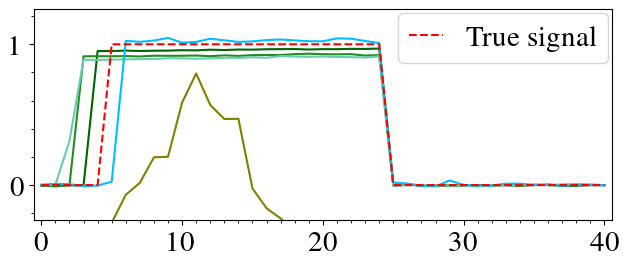

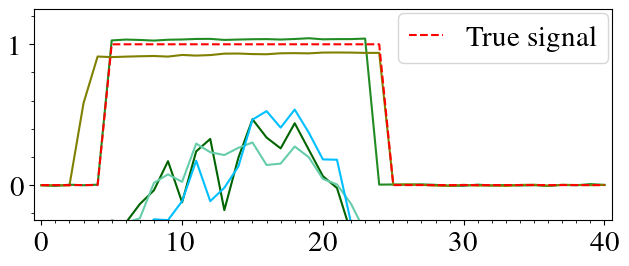

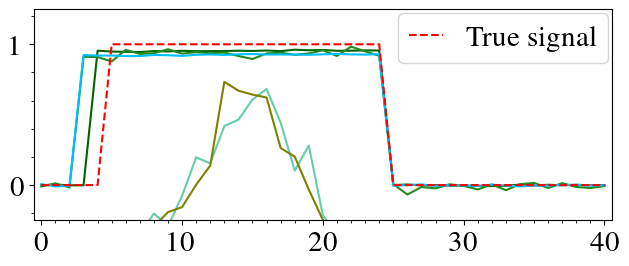

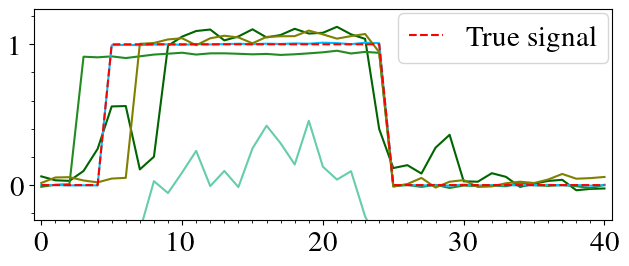

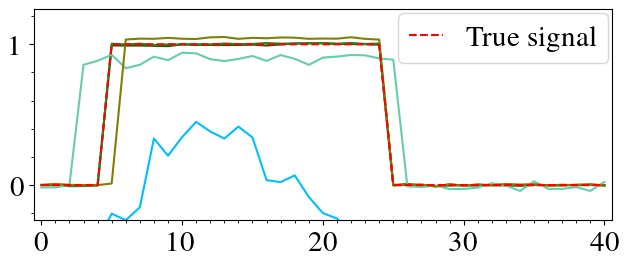

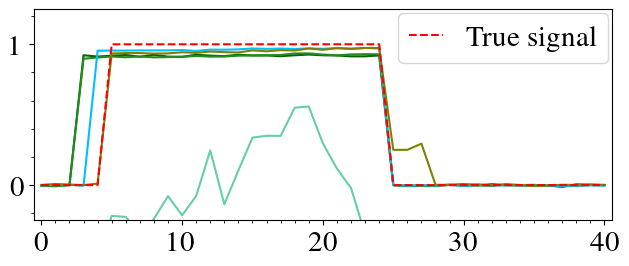

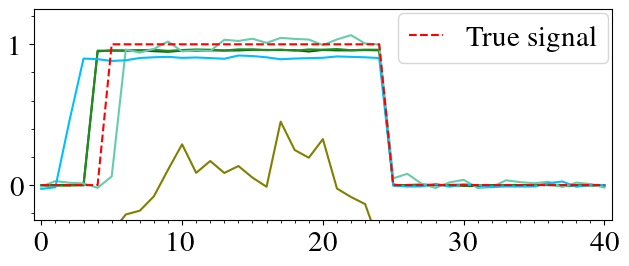

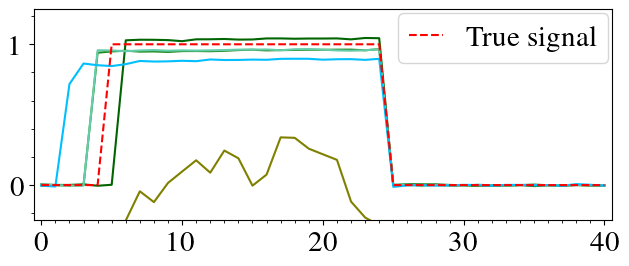

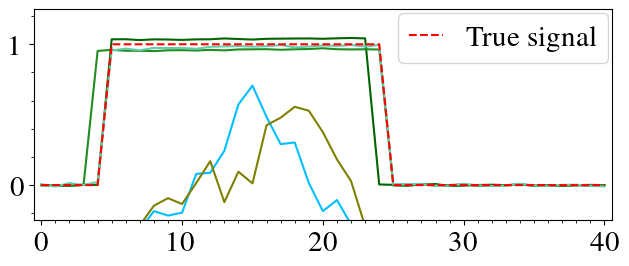

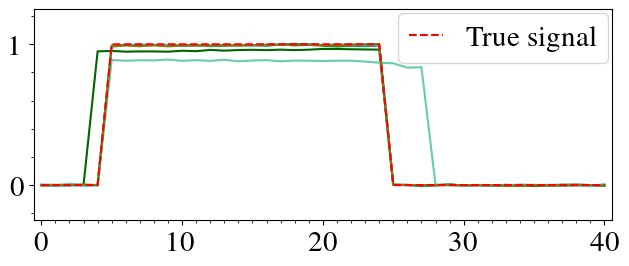

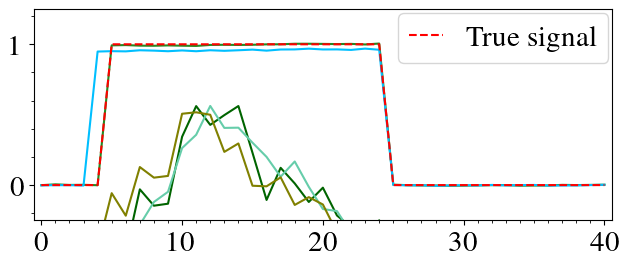

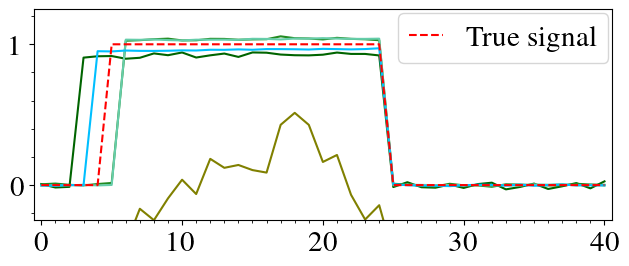

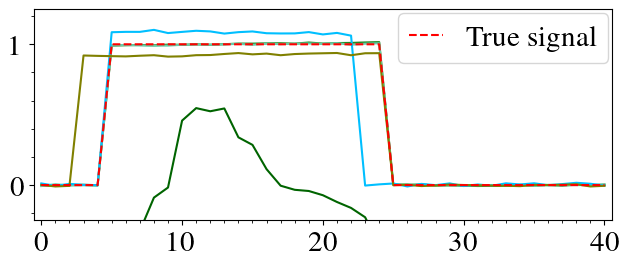

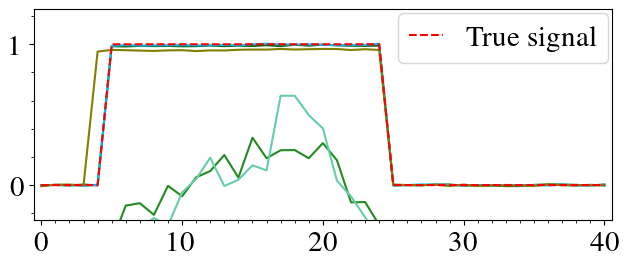

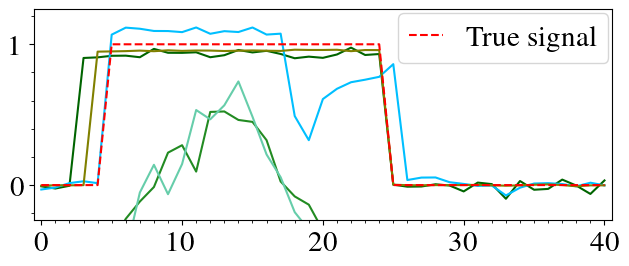

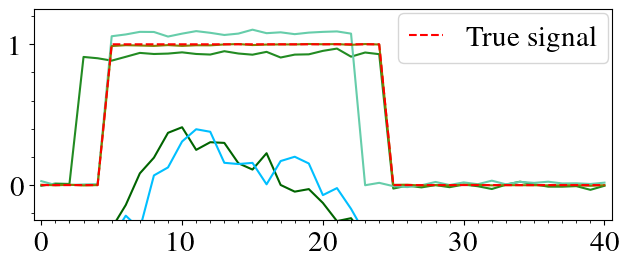

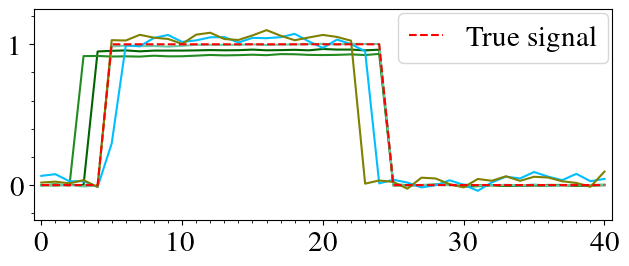

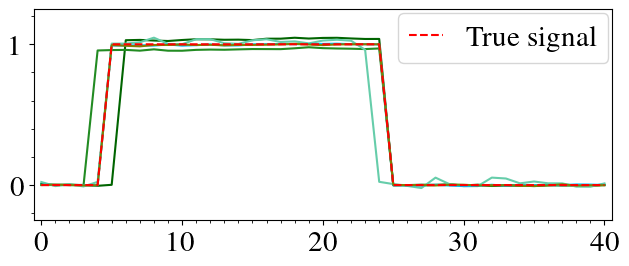

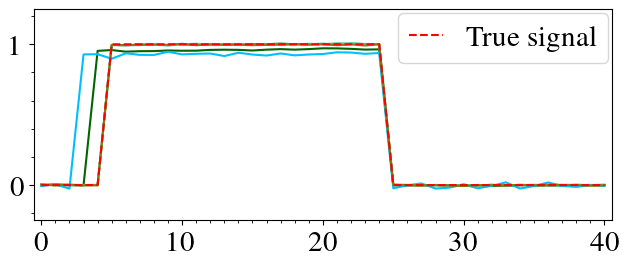

In [81]:
   
if length > 3:
    if plot_signal_samples:
        fig_s, ax_s = plt.subplots()
        ax_s.plot(signal_true.to('cpu'), c='r', linestyle="dashed")
        ax_s.plot(signal_samples.to('cpu').T)
        ax_s.plot(signal_true.to('cpu'), c='r', linestyle="dashed")
        ax_s.legend(["True signal"])
        plt.title(f"Samples of true signal distribution")
        fig_s.tight_layout()
        plt.savefig(FIG_PATH + 'signal_samples.png')
        plt.savefig(FIG_PATH + 'signal_samples.pdf')
    

    aligned_samples = align(model_samples, signal_true)
    # tmp = torch.zeros_like(model_samples)
    # tmp[:, :-1] += model_samples[:, 1:] - model_samples[:, :-1]
    # tmp[:, -1] = model_samples[:, 0] - model_samples[:, -1]
    # tmp_idxs = tmp.max(dim=-1)[1]
    # aligned_samples = circulant(model_samples, dim=-1)[range(diffusion_samples), :, tmp_idxs]

    colors = ["darkgreen", "forestgreen", "mediumaquamarine", "deepskyblue", "olive"]
    for plot_idx in range(diffusion_samples//5):
        fig_m, ax_m = plt.subplots()
        ax_m.plot(
            signal_true.to('cpu'), 
            c='r', 
            linestyle="dashed", 
            linewidth=1.5,
            zorder=2,
        )
        for idx, sample in enumerate(aligned_samples[5*plot_idx:5*(plot_idx+1), :].to('cpu')):
            ax_m.plot(
                sample, 
                color=colors[idx],
                linewidth=1.5,
                zorder=1,
            )
        ax_m.legend(
            ["True signal"],
            fontsize=21, 
            loc='upper right', 
            bbox_to_anchor=(1.02, 1.05, 0, 0),
            handlelength=1.15,
        )
        ax_m.set_xlim(-0.5, 40.5)
        ax_m.set_ylim(-0.25, 1.25)
        ax_m.set_xticks(range(0, 41, 10))
        ax_m.set_xticks(range(41), minor=True)
        ax_m.set_yticks([0, 1])
        ax_m.set_yticks(np.arange(-0.2, 1.4, 0.2), minor=True)
        ax_m.set_xticklabels(
            range(0, 41, 10),
            fontsize=21,
        )
        ax_m.set_yticklabels(
            [0, 1], 
            fontsize=21,
            # verticalalignment='baseline',
            # horizontalalignment='left',
        )
        ax_m.set_aspect(10.)
        fig_m.tight_layout()
        if use_none_cond:
            # plt.title(f"Prior samples aligned with true signal")
            plt.savefig(FIG_PATH + f'prior_samples_{plot_idx}.png')
            plt.savefig(FIG_PATH + f'prior_samples_{plot_idx}.pdf')
        else:
            # plt.title(f"Posterior samples aligned with true signal")
            plt.savefig(FIG_PATH + f'posterior_samples_{plot_idx}.png')
            plt.savefig(FIG_PATH + f'posterior_samples_{plot_idx}.pdf')

In [54]:
# def update_quiver(n, T, Q, X, Y, F):
#     S_n, _, _ = F(T[n-1])
#     U_n = S_n[:, :, 0].to('cpu')
#     V_n = S_n[:, :, 1].to('cpu')
#     Q.set_UVC(U_n,V_n)
#     return Q

# timesteps = torch.linspace(1., min_diffusion_time_plt, num_steps_plt)
# anim = animation.FuncAnimation(
#     fig, 
#     update_quiver, 
#     fargs=(timesteps, Q, XY[:, :, 0], XY[:, :, 1], F), 
#     frames=num_steps_plt, 
#     interval=100,
#     blit=False,
# )

# plt.title(f"Projection of 3D-scores for diffusion time")
# anim.save('./../figs/smld/diffusion_scores.mp4')